# Using Pipelines

The **dataprocessing** library works with the **Pipeline** class from SKLearn. In this notebook, we show a few examples of how to use pipelines with transformers from the **dataprocessing** library.

In [1]:
from typing import Union

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import uci_dataset as database

from raimitigations.utils import evaluate_set, split_data
import raimitigations.dataprocessing as dp

In this notebook, we'll use the thyroid disease dataset. Let's load this dataset and take a look at it:

In [2]:
df = database.load_thyroid_disease()
label_col = "sick-euthyroid"
df[label_col] = df[label_col].replace({"sick-euthyroid": 1, "negative": 0})
df

,sick-euthyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,1,72.0,M,f,f,f,f,f,f,f,...,y,1.0,y,83.0,y,0.95,y,87.0,n,NaN
1,1,45.0,F,f,f,f,f,f,f,f,...,y,1.0,y,82.0,y,0.73,y,112.0,n,NaN
2,1,64.0,F,f,f,f,f,f,f,f,...,y,1.0,y,101.0,y,0.82,y,123.0,n,NaN
3,1,56.0,M,f,f,f,f,f,f,f,...,y,0.8,y,76.0,y,0.77,y,99.0,n,NaN
4,1,78.0,F,t,f,f,f,t,f,f,...,y,0.3,y,87.0,y,0.95,y,91.0,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,0,40.0,F,f,f,f,f,f,f,f,...,y,1.2,y,76.0,y,0.90,y,84.0,n,NaN
3159,0,69.0,F,f,f,f,f,f,f,f,...,y,1.8,y,126.0,y,1.02,y,124.0,n,NaN
3160,0,58.0,F,f,f,f,f,f,f,f,...,y,1.7,y,86.0,y,0.91,y,95.0,n,NaN
3161,0,29.0,F,f,f,f,f,f,f,f,...,y,1.8,y,99.0,y,1.01,y,98.0,n,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sick-euthyroid             3163 non-null   int64  
 1   age                        2717 non-null   float64
 2   sex                        3090 non-null   object 
 3   on_thyroxine               3163 non-null   object 
 4   query_on_thyroxine         3163 non-null   object 
 5   on_antithyroid_medication  3163 non-null   object 
 6   thyroid_surgery            3163 non-null   object 
 7   query_hypothyroid          3163 non-null   object 
 8   query_hyperthyroid         3163 non-null   object 
 9   pregnant                   3163 non-null   object 
 10  sick                       3163 non-null   object 
 11  tumor                      3163 non-null   object 
 12  lithium                    3163 non-null   object 
 13  goitre                     3163 non-null   objec

## Comparing different pipelines

Using pipelines allow us to compare different pre-processing methods in a easy and efficient way. Here we will build different pipelines, each with different transformations, and then compare the results obtained for each one. But before we can do this, let's build a function that calls the pipeline's fit and predict_proba methods, followed by the computation of a few metrics, such as ROC AUC, F1, precision, recall, accuracy, and the confusion matrix. To compute these metrics, we use the **evaluate_set** function from the **utils.model_utils** module.

In [4]:
def fit_and_get_results_bin(
    pipeline: Pipeline,
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
    best_th_auc: bool=True
):
    pipeline.fit(x_train, y_train)
    pred_test = pipeline.predict_proba(x_test)
    _ = evaluate_set(y_test, pred_test, regression=False, plot_pr=False, best_th_auc=best_th_auc, classes=pipeline.classes_)

We'll also test the efficiency of using scalers over the numerical features of the dataset. It only makes sense to scale the numerical features that doesn't represent one-hot encodings, so let's get the list of all float columns from the dataset. This list will represent the list of columns to which we'll apply the scaler transformations.

In [5]:
float_cols = [col for col in df.columns if 'float' in df[col].dtype.name]
float_cols

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

Each pipeline can have different transformations. However, some of these transformations could be repeated among different pipelines. For example, all pipelines should have an imputer transformer. In the following cell we'll instantiate a few transformers in an effort to simplify the pipeline creation process.

In [6]:
ohe_encoder = dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)
imputer = dp.BasicImputer(numerical={'missing_values':np.nan,
									'strategy':'constant',
									'fill_value':-1},
                          verbose=False)
feat_sel = dp.CatBoostSelection(catboost_log=False, verbose=False)
cor_feat = dp.CorrelatedFeatures(save_json=False)

Now we just have to split the original dataset into train and test sets. After that, we can start comparing the different pipelines.

In [7]:
train_x, test_x, train_y, test_y = split_data(df, label_col, test_size=0.2)

### Pipeline 0

[[501  73]
 [  7  52]]


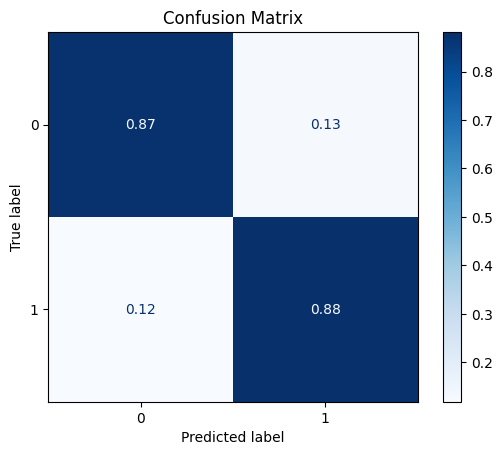

ROC AUC: 0.9299001948857261
Precision: 0.7011102362204724
Recall: 0.877089115927479
F1: 0.7456401189423771
Accuracy: 0.8736176935229067
Optimal Threshold (ROC curve): 0.1250311491470217
Optimal Threshold (Precision x Recall curve): 0.251147863435757
Threshold used: 0.1250311491470217


In [8]:
pipe0 = Pipeline([
            ("encoder", ohe_encoder),
            ("imputer", imputer),
            ("estimator", SVC(probability=True)),
        ])
fit_and_get_results_bin(pipe0, train_x, train_y, test_x, test_y, best_th_auc=True)

### Pipeline 1

[[555  19]
 [  7  52]]


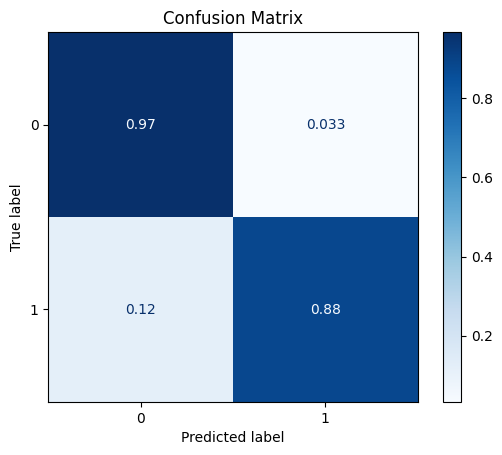

ROC AUC: 0.9250280517333019
Precision: 0.8599694250914741
Recall: 0.9241274434536113
F1: 0.888556338028169
Accuracy: 0.9589257503949447
Optimal Threshold (ROC curve): 0.29745720239980394
Optimal Threshold (Precision x Recall curve): 0.43828324901046595
Threshold used: 0.29745720239980394


In [9]:
pipe1 = Pipeline([
            ("encoder", ohe_encoder),
            ("imputer", imputer),
            ("scaler", dp.DataStandardScaler(include_cols=float_cols, verbose=False)),
            ("estimator", SVC(probability=True)),
        ])
fit_and_get_results_bin(pipe1, train_x, train_y, test_x, test_y, best_th_auc=True)

### Pipeline 2

/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


[[548  26]
 [  7  52]]


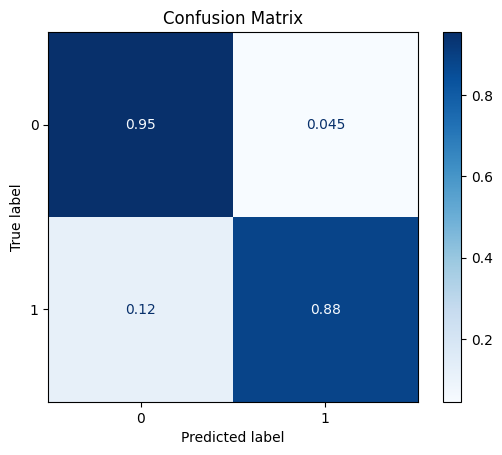

ROC AUC: 0.9340046063898896
Precision: 0.827027027027027
Recall: 0.9180298824780015
F1: 0.8649473405183838
Accuracy: 0.9478672985781991
Optimal Threshold (ROC curve): 0.22808377020466744
Optimal Threshold (Precision x Recall curve): 0.4029785100782772
Threshold used: 0.22808377020466744


In [10]:
pipe2 = Pipeline([
            ("encoder", ohe_encoder),
            ("imputer", imputer),
            ("scaler", dp.DataStandardScaler(include_cols=float_cols)),
            ("feat_sel", feat_sel),
            ("estimator", SVC(probability=True)),
        ])
fit_and_get_results_bin(pipe2, train_x, train_y, test_x, test_y, best_th_auc=True)

## Using SKLearn and Dataprocessing transformers in the same Pipeline

The transformations in SKLearn always return a numpy array, while the transformers in our **dataprocessing** library usually operate over a Pandas DataFrame (although these transformers also accept numpy arrays as input). The latter uses dataframes in order to allow it to filter specific columns, just like we did when we created the DataStandardScaler object and specified that only the columns in the **float_cols** list should be scaled. With a numpy array, we can also do this, but instead of using column names, we are forced to use the column indices instead, since numpy arrays doesn't have column names.

In this scenario, when we place a transformer from the SKLearn library before a transformer from the **dataprocessing** library in a Pipeline, we must be aware that we'll lose the column names (considering that the input to the Pipeline is indeed a Pandas dataframe) after the sklearn transformer calls its transform() method. This way, all of the transformers after this point will have to use column indices instead of column names, as depicted in the following example. In this example, we'll use the SKLearn's **SimpleImputer** instead of using our similar class, the **BasicImputer**, just so we can test the behavior of the Pipeline class with transformers from both SKLearn and **dataprocessing** libraries. We'll execute the following steps in this pipeline: 

1. encode the columns "sex" and "on_thyroxine" using one-hot encoding,
2. impute missing data by replacing it with a -100 value,
3. apply a min-max scaler over the column "age",
4. apply an ordinal encoding over all of the remaining categorical variables.

In [11]:
pipe = Pipeline([
            ("encoder_ohe", dp.EncoderOHE(col_encode=["sex", "on_thyroxine"])), # dataprocessing
            ("imputer", SimpleImputer(strategy="constant", fill_value=-100)),   # sklearn
            ("scaler", dp.DataMinMaxScaler(include_cols=[0])),                  # dataprocessing
            ("ordinal_encoder", dp.EncoderOrdinal(verbose=False)),              # dataprocessing
        ])
pipe.fit(train_x, train_y)
new_x_test = pipe.transform(test_x)
new_x_test

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.641414,0,0,0,0,0,0,0,0,0,...,10.0,1,0.9,1,12.0,0,-100,0,0,0
1,0.929293,0,0,0,0,0,0,0,0,0,...,162.0,1,1.03,1,158.0,0,-100,0,0,0
2,0.000000,0,0,0,0,0,0,0,0,0,...,175.0,1,0.86,1,204.0,0,-100,0,1,0
3,0.858586,0,0,0,1,0,0,0,0,0,...,69.0,1,0.83,1,83.0,0,-100,0,0,0
4,0.808081,0,0,0,0,0,0,0,0,0,...,130.0,1,0.94,1,138.0,0,-100,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,0.863636,0,0,0,0,0,0,0,0,0,...,137.0,1,1.11,1,123.0,0,-100,1,0,0
629,0.606061,0,0,0,1,0,0,0,0,0,...,110.0,1,0.92,1,120.0,0,-100,0,0,0
630,0.000000,0,0,0,0,0,0,0,0,0,...,79.0,1,1.0,1,80.0,0,-100,0,0,0
631,0.858586,0,0,0,1,0,0,0,0,0,...,68.0,1,0.0,1,78.0,0,-100,0,0,0


As we can see in the previous cell, we used column names when instantiating the EncoderOHE class, but used column indices when specifying the columns that should be scaled using the DataMinMaxScaler. This is required because the SimpleImputer object returns a numpy array, which has no column names. From there onward, the column names are lost. We could use indices for all transformers. This would result in the same new x test set, as showed in the following cell:

In [12]:
pipe = Pipeline([
            ("encoder_ohe", dp.EncoderOHE(col_encode=[1, 2])),                  # dataprocessing
            ("imputer", SimpleImputer(strategy="constant", fill_value=-100)),   # sklearn
            ("scaler", dp.DataMinMaxScaler(include_cols=[0])),                  # dataprocessing
            ("ordinal_encoder", dp.EncoderOrdinal(verbose=False)),              # dataprocessing
        ])
pipe.fit(train_x, train_y)
new_x_test = pipe.transform(test_x)
new_x_test

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.641414,0,0,0,0,0,0,0,0,0,...,10.0,1,0.9,1,12.0,0,-100,0,0,0
1,0.929293,0,0,0,0,0,0,0,0,0,...,162.0,1,1.03,1,158.0,0,-100,0,0,0
2,0.000000,0,0,0,0,0,0,0,0,0,...,175.0,1,0.86,1,204.0,0,-100,0,1,0
3,0.858586,0,0,0,1,0,0,0,0,0,...,69.0,1,0.83,1,83.0,0,-100,0,0,0
4,0.808081,0,0,0,0,0,0,0,0,0,...,130.0,1,0.94,1,138.0,0,-100,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,0.863636,0,0,0,0,0,0,0,0,0,...,137.0,1,1.11,1,123.0,0,-100,1,0,0
629,0.606061,0,0,0,1,0,0,0,0,0,...,110.0,1,0.92,1,120.0,0,-100,0,0,0
630,0.000000,0,0,0,0,0,0,0,0,0,...,79.0,1,1.0,1,80.0,0,-100,0,0,0
631,0.858586,0,0,0,1,0,0,0,0,0,...,68.0,1,0.0,1,78.0,0,-100,0,0,0


Using column indices is not as intuitive as using column names. Using indices is also more error prone, especially when dealing with a pipeline with transformations that could change the order of the columns, such as the EncoderOHE and feature selection methods. In these scenarios, the index of a column might change in the middle of the pipeline, making it harder for the user to know exactly the column index that they should use to apply a specific operation over a specific column. Therefore, it is of interest to the user to continue to use only column names when possible. In the remainder of this section, we'll present three solutions to this problem.

### Solution 1: use the Pipeline class with only transformers from the dataprocessing library

The first solution is pretty straightforward: use only transformers from the **dataprocessing** library. Note that an estimator from SKLearn or other libraries could still be used in the end of the pipeline, but the transformers used must be always from the **dataprocessing** library. Since all transformers from this library operate over Pandas Dataframes, and if all transformers in the pipeline return dataframes, then at no point in the pipeline this dataframe will be lost. This guarantees that all transformers will receive a dataframe as input, without losing the column names. As a result, all transformers are allowed to use filters based on column names.

Let's recreate the previous pipeline using only transformers from our library. For this, we'll replace the **SimpleImputer** by the **BasicImputer**. This allows us to use column names when specifying which columns the **DataMinMaxScaler** should be applied on:

In [13]:
miss_dict ={'missing_values':np.nan, 'strategy':'constant', 'fill_value':-100}

pipe = Pipeline([
            ("encoder_ohe", dp.EncoderOHE(col_encode=["sex", "on_thyroxine"])),                         # dataprocessing
            ("imputer", dp.BasicImputer(numerical=miss_dict, categorical=miss_dict, verbose=False)),    # dataprocessing
            ("scaler", dp.DataMinMaxScaler(include_cols=["age"])),                                      # dataprocessing
            ("ordinal_encoder", dp.EncoderOrdinal(verbose=False)),                                      # dataprocessing
        ])
pipe.fit(train_x, train_y)
new_x_test = pipe.transform(test_x)
new_x_test

,age,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,sex_M,sex_nan,on_thyroxine_t
3073,0.641414,0,0,0,0,0,0,0,0,0,...,10.0,1,0.90,1,12.0,0,-100.0,0,0,0
1839,0.929293,0,0,0,0,0,0,0,0,0,...,162.0,1,1.03,1,158.0,0,-100.0,0,0,0
3096,0.000000,0,0,0,0,0,0,0,0,0,...,175.0,1,0.86,1,204.0,0,-100.0,0,1,0
1147,0.858586,0,0,0,1,0,0,0,0,0,...,69.0,1,0.83,1,83.0,0,-100.0,0,0,0
2413,0.808081,0,0,0,0,0,0,0,0,0,...,130.0,1,0.94,1,138.0,0,-100.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.863636,0,0,0,0,0,0,0,0,0,...,137.0,1,1.11,1,123.0,0,-100.0,1,0,0
2526,0.606061,0,0,0,1,0,0,0,0,0,...,110.0,1,0.92,1,120.0,0,-100.0,0,0,0
593,0.000000,0,0,0,0,0,0,0,0,0,...,79.0,1,1.00,1,80.0,0,-100.0,0,0,0
2203,0.858586,0,0,0,1,0,0,0,0,0,...,68.0,1,0.00,1,78.0,0,-100.0,0,0,0


### Solution 2: use the SklearnTransformerWrapper class

If there is a specific transformer from the **SKLearn** library not present in the **dataprocessing** library, then the user has no alternative but to use the **SKLearn** transformer. The **SklearnTransformerWrapper** class, from the **Feature Engine library**, is a wrapper for transformers from the **SKLearn** library that forces, among other features, forces the output of the transformers to be a pandas dataframe if the input is also a dataframe. This solves our problem, since this way the dataframe is never lost. To do this, the user must pass the transformer object to the **SklearnTransformerWrapper** constructor when instantiating it. The **SklearnTransformerWrapper** object will then allow users to use the fit and transform methods, but now, the transform method returns a pandas dataframe instead of a numpy array.

The following cell shows how to use the SklearnTransformerWrapper to wrap a transformer from the SKLearn library and then use it in a Pipeline. Before running the following cell, make sure to install the **feature-engine** package [following this link.](https://pypi.org/project/feature-engine/#:~:text=Feature-engine%20is%20a%20Python%20library%20with%20multiple%20transformers,parameters%20from%20the%20data%20and%20then%20transform%20it.)

In [14]:
from feature_engine.wrappers import SklearnTransformerWrapper

imputer = SklearnTransformerWrapper(transformer=SimpleImputer(strategy="constant", fill_value=-100))

pipe = Pipeline([
            ("encoder_ohe", dp.EncoderOHE(col_encode=["sex", "on_thyroxine"])), # dataprocessing
            ("imputer", imputer),                                               # sklearn
            ("scaler", dp.DataMinMaxScaler(include_cols=["age"])),                  # dataprocessing
            ("ordinal_encoder", dp.EncoderOrdinal(verbose=False)),              # dataprocessing
        ])
pipe.fit(train_x, train_y)
new_x_test = pipe.transform(test_x)
new_x_test

,age,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,sex_M,sex_nan,on_thyroxine_t
3073,0.641414,0,0,0,0,0,0,0,0,0,...,10.0,1,0.9,1,12.0,0,-100,0,0,0
1839,0.929293,0,0,0,0,0,0,0,0,0,...,162.0,1,1.03,1,158.0,0,-100,0,0,0
3096,0.000000,0,0,0,0,0,0,0,0,0,...,175.0,1,0.86,1,204.0,0,-100,0,1,0
1147,0.858586,0,0,0,1,0,0,0,0,0,...,69.0,1,0.83,1,83.0,0,-100,0,0,0
2413,0.808081,0,0,0,0,0,0,0,0,0,...,130.0,1,0.94,1,138.0,0,-100,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.863636,0,0,0,0,0,0,0,0,0,...,137.0,1,1.11,1,123.0,0,-100,1,0,0
2526,0.606061,0,0,0,1,0,0,0,0,0,...,110.0,1,0.92,1,120.0,0,-100,0,0,0
593,0.000000,0,0,0,0,0,0,0,0,0,...,79.0,1,1.0,1,80.0,0,-100,0,0,0
2203,0.858586,0,0,0,1,0,0,0,0,0,...,68.0,1,0.0,1,78.0,0,-100,0,0,0


### Solution 3: Wrap the Pipeline class and apply solution 2 automatically

We can also create a wrapper over the **Pipeline** class that automatically applies Solution 2 to the transformers in the pipeline. This extension, called here the **PipelineWrapper**, provides a simple modification: all transformers that are not from the **dataprocessing** library are wrapped around the **SklearnTransformerWrapper** class. Therefore, the **PipelineWrapper** executes the previous solution internally, removing the burden of wrapping all of **SKLearn's** transformers from the hands of the user. The **PipelineWrapper** doesn't change any other behavior from the **Pipeline** class, and therefore, the latter can be replaced by the former without any changes in the behavior of the code.

First, let's create the **PipelineWrapper** class. This class inherits from the **Pipeline** class. The only modification that we make is that we call a new method, called **_wrap_skl_transf()**, in the *init* method. This method will check all transformers in the pipeline and wrap all of the SKLearn's transformers in the **SklearnTransformerWrapper**. This guarantees that, if the input is a pandas dataframe, the transformers from SKLearn will also output a dataframe.

In [15]:
from feature_engine.wrappers.wrappers import _ALL_TRANSFORMERS

class PipelineWrapper(Pipeline):

    # -----------------------------------
    def __init__(self, steps, *, memory=None, verbose=False):
        super().__init__(steps, memory=memory, verbose=verbose)
        self._wrap_skl_transf()

    # -----------------------------------
    def _wrap_skl_transf(self):
        for i in range(len(self.steps)):
            name, transform = self.steps[i]
            if not isinstance(transform, dp.DataProcessing):
                if not isinstance(transform, SklearnTransformerWrapper):
                    if transform.__class__.__name__ in _ALL_TRANSFORMERS:
                        transform = SklearnTransformerWrapper(transformer=transform)
                        self.steps[i] = (name, transform)

Now let's use the **PipelineWrapper** instead of the **Pipeline** class. Note that nothing changes, except that now we can use the column names even after a transformer from the **SKLearn** library.

In [16]:
pipe = PipelineWrapper([
            ("encoder_ohe", dp.EncoderOHE(col_encode=["sex", "on_thyroxine"])), # dataprocessing
            ("imputer", SimpleImputer(strategy="constant", fill_value=-100)),   # sklearn
            ("scaler", dp.DataMinMaxScaler(include_cols=["age"])),              # dataprocessing
            ("ordinal_encoder", dp.EncoderOrdinal(verbose=False)),              # dataprocessing
        ])
pipe.fit(train_x, train_y)
new_x_test = pipe.transform(test_x)
new_x_test

,age,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,sex_M,sex_nan,on_thyroxine_t
3073,0.641414,0,0,0,0,0,0,0,0,0,...,10.0,1,0.9,1,12.0,0,-100,0,0,0
1839,0.929293,0,0,0,0,0,0,0,0,0,...,162.0,1,1.03,1,158.0,0,-100,0,0,0
3096,0.000000,0,0,0,0,0,0,0,0,0,...,175.0,1,0.86,1,204.0,0,-100,0,1,0
1147,0.858586,0,0,0,1,0,0,0,0,0,...,69.0,1,0.83,1,83.0,0,-100,0,0,0
2413,0.808081,0,0,0,0,0,0,0,0,0,...,130.0,1,0.94,1,138.0,0,-100,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.863636,0,0,0,0,0,0,0,0,0,...,137.0,1,1.11,1,123.0,0,-100,1,0,0
2526,0.606061,0,0,0,1,0,0,0,0,0,...,110.0,1,0.92,1,120.0,0,-100,0,0,0
593,0.000000,0,0,0,0,0,0,0,0,0,...,79.0,1,1.0,1,80.0,0,-100,0,0,0
2203,0.858586,0,0,0,1,0,0,0,0,0,...,68.0,1,0.0,1,78.0,0,-100,0,0,0
